<h2>Customer Churn Analysis<h1>
<h2>Saket Dronamraju (22BDS0270)</h2>
<h2>Anagha R Warrier (22BDS0446)</h2>


Loading the Dataset

In [2]:
# Basic libraries
import pandas as pd
import numpy as np
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Load dataset
file_path = "02 Churn-Dataset.xlsx"
df = pd.read_excel(file_path, sheet_name="01 Churn-Dataset")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.5,0,0,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0,0,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,3,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,Yes


Data Transformation

In [3]:
# Convert TotalCharges to numeric (it’s object type)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Check for any NaNs after conversion
print(df["TotalCharges"].isna().sum())

# Fill NaNs with 0 (or you can drop them)
df["TotalCharges"].fillna(0, inplace=True)

# Encode binary categorical variables
binary_map = {"Yes": 1, "No": 0, "Female": 0, "Male": 1}
df.replace(binary_map, inplace=True)

# Encode Churn separately
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# One-hot encode categorical variables with multiple categories
df = pd.get_dummies(df, columns=[
    "InternetService", "Contract", "PaymentMethod", "MultipleLines",
    "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies"
], drop_first=True)

# Drop customerID (not useful for analysis)
df.drop("customerID", axis=1, inplace=True)

df.head()


11


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,numAdminTickets,...,OnlineBackup_1,OnlineBackup_No internet service,DeviceProtection_1,DeviceProtection_No internet service,TechSupport_1,TechSupport_No internet service,StreamingTV_1,StreamingTV_No internet service,StreamingMovies_1,StreamingMovies_No internet service
0,0,0,1,0,1,0,1,29.85,29.85,0,...,True,False,False,False,False,False,False,False,False,False
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,False,False,True,False,False,False,False,False,False,False
2,1,0,0,0,2,1,1,53.85,108.15,0,...,True,False,False,False,False,False,False,False,False,False
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,False,False,True,False,True,False,False,False,False,False
4,0,0,0,0,2,1,1,70.70,151.65,0,...,False,False,False,False,False,False,False,False,False,False


In [4]:
# Average charges per month (avoid division by zero)
df["AvgChargesPerMonth"] = df.apply(
    lambda x: x["TotalCharges"]/x["tenure"] if x["tenure"] > 0 else 0, axis=1
)

# Bin tenure into categories
df["TenureGroup"] = pd.cut(df["tenure"], bins=[0,12,24,48,60,72], 
                           labels=["0-12","13-24","25-48","49-60","61-72"])
df.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,numAdminTickets,...,DeviceProtection_1,DeviceProtection_No internet service,TechSupport_1,TechSupport_No internet service,StreamingTV_1,StreamingTV_No internet service,StreamingMovies_1,StreamingMovies_No internet service,AvgChargesPerMonth,TenureGroup
0,0,0,1,0,1,0,1,29.85,29.85,0,...,False,False,False,False,False,False,False,False,29.850000,0-12
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,True,False,False,False,False,False,False,False,55.573529,25-48
2,1,0,0,0,2,1,1,53.85,108.15,0,...,False,False,False,False,False,False,False,False,54.075000,0-12
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,True,False,True,False,False,False,False,False,40.905556,25-48
4,0,0,0,0,2,1,1,70.70,151.65,0,...,False,False,False,False,False,False,False,False,75.825000,0-12


Univariate Analysis

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


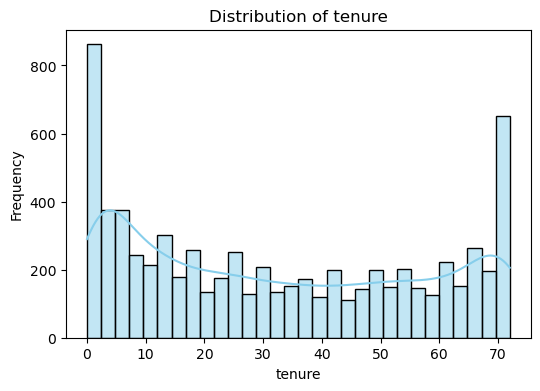

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


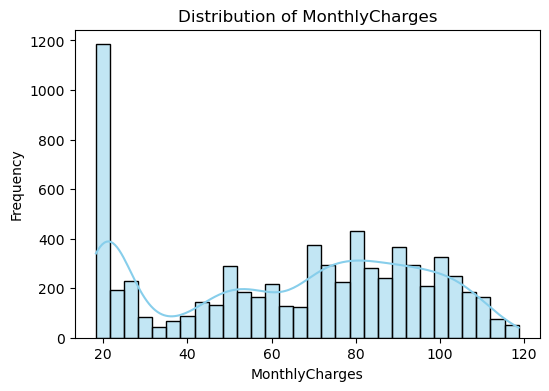

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


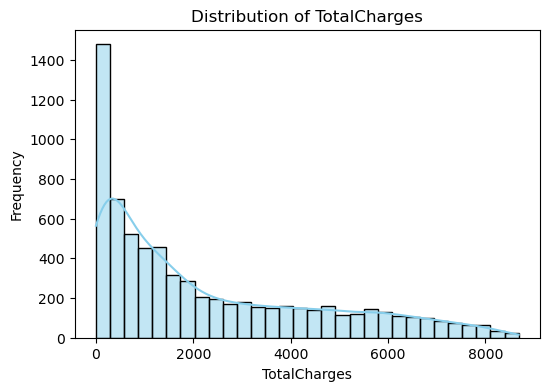

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


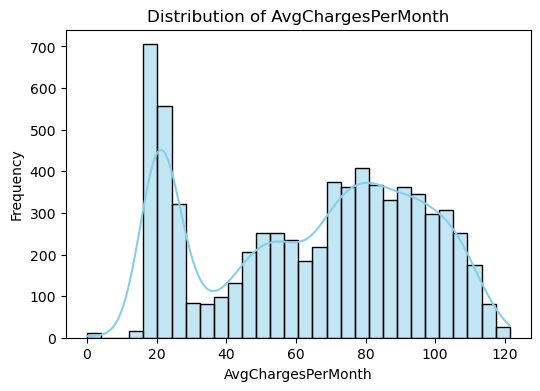

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


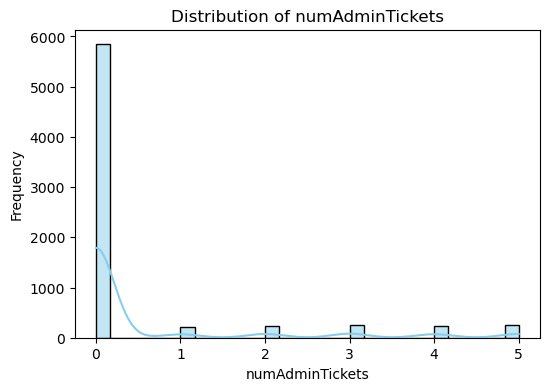

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


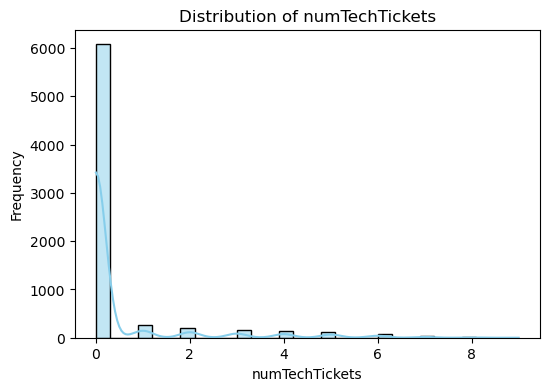

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Numerical Features

num_cols = ["tenure", "MonthlyCharges", "TotalCharges", 
            "AvgChargesPerMonth", "numAdminTickets", "numTechTickets"]

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30, color="skyblue")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()



Bivariate Analysis

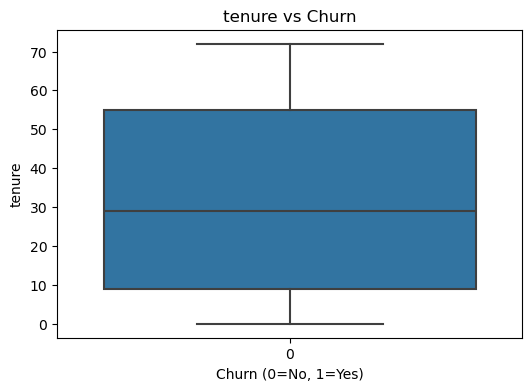

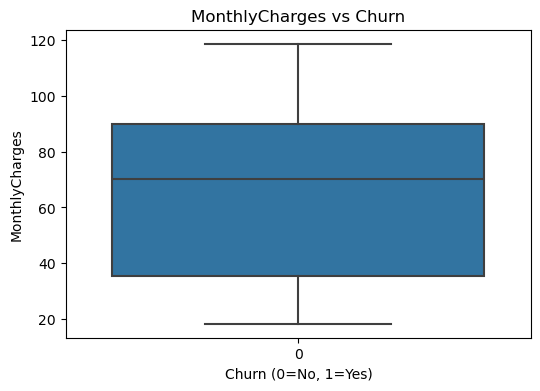

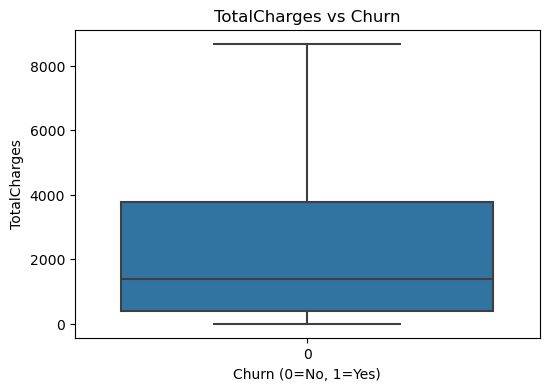

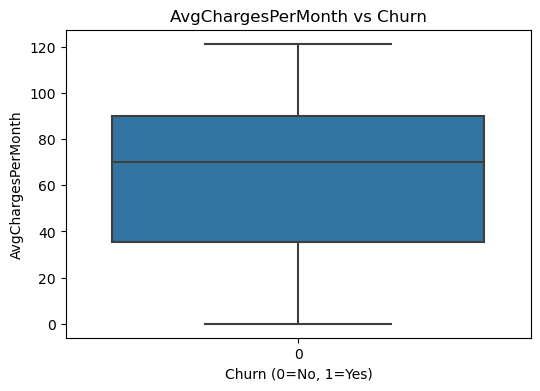

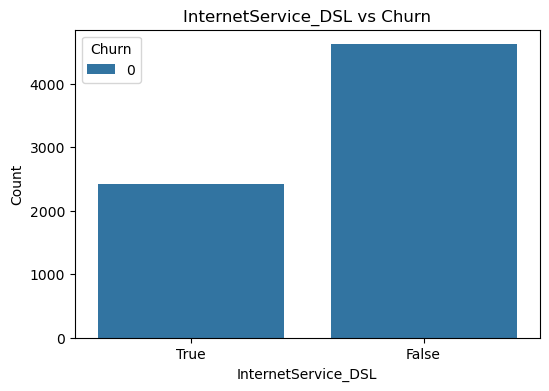

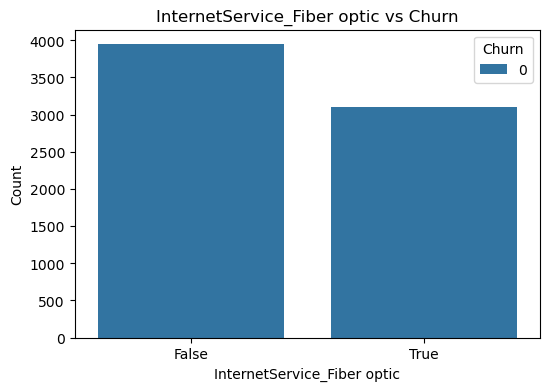

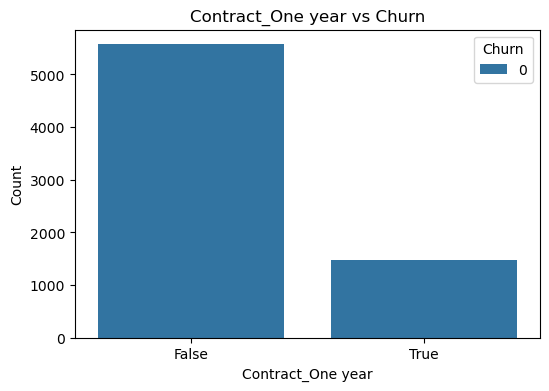

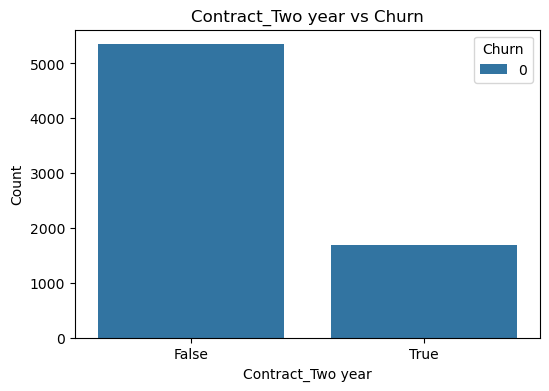

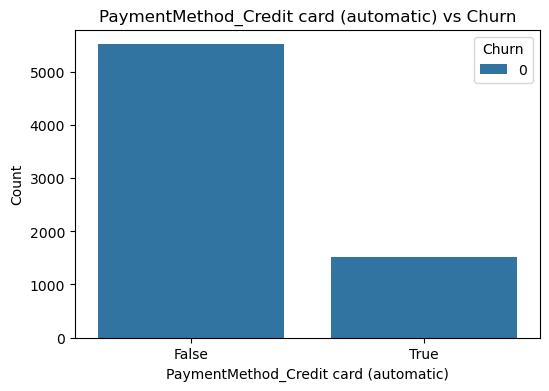

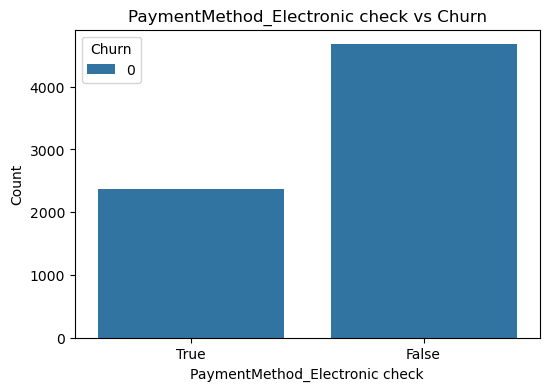

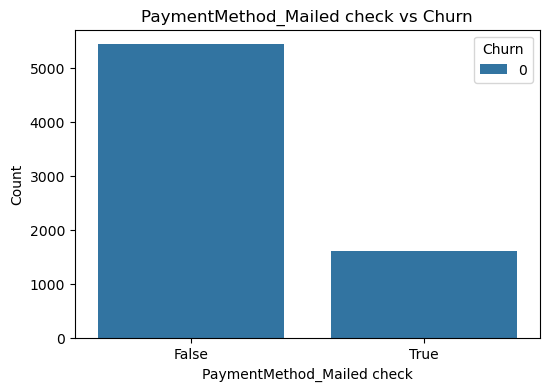

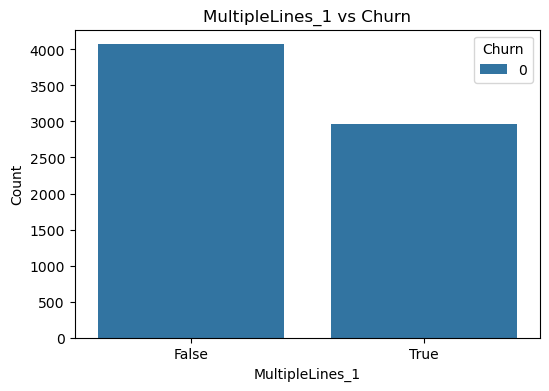

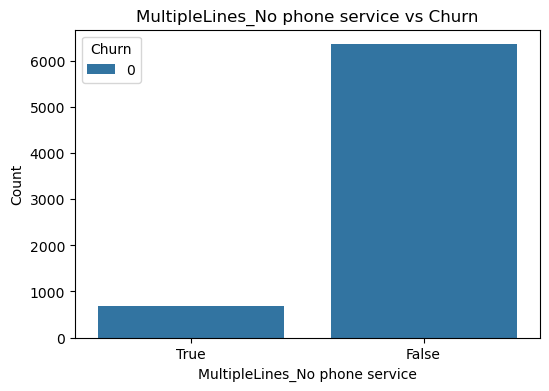

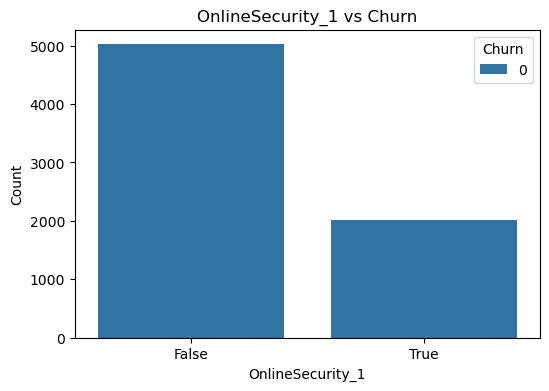

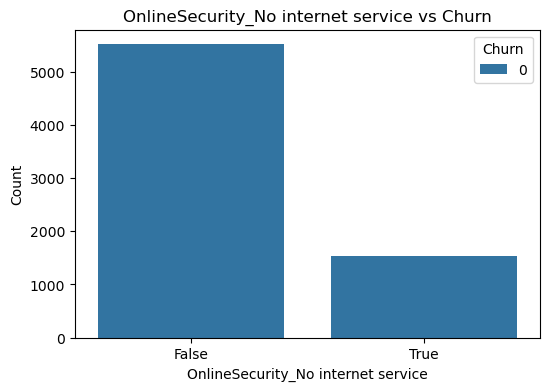

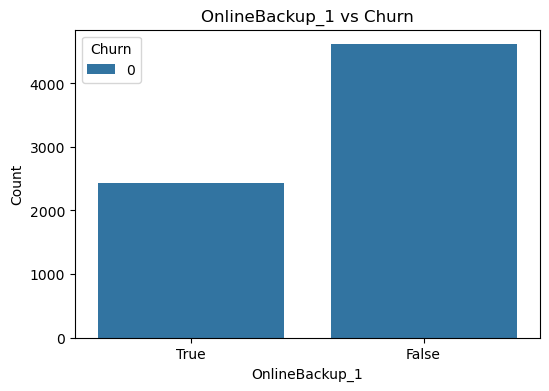

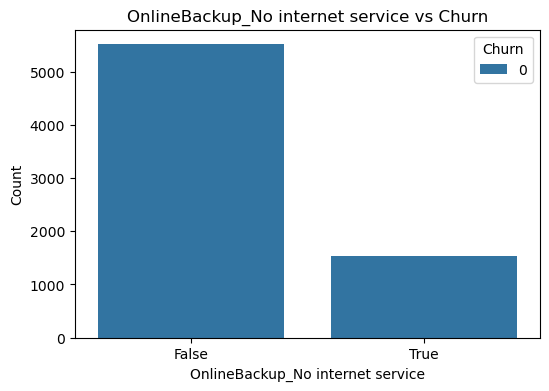

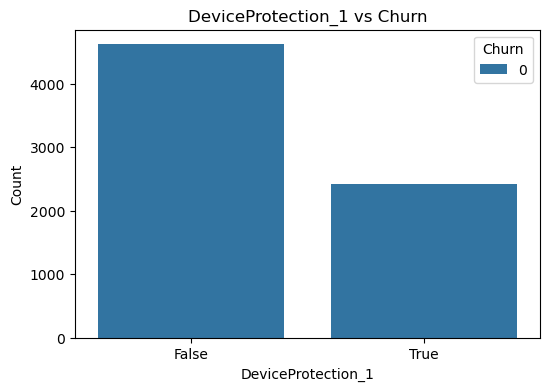

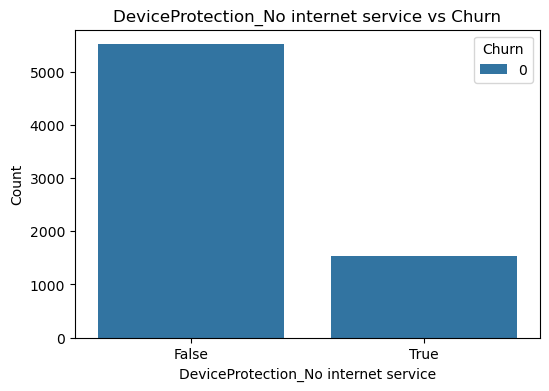

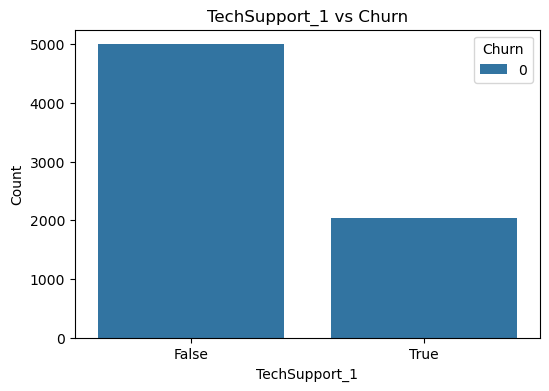

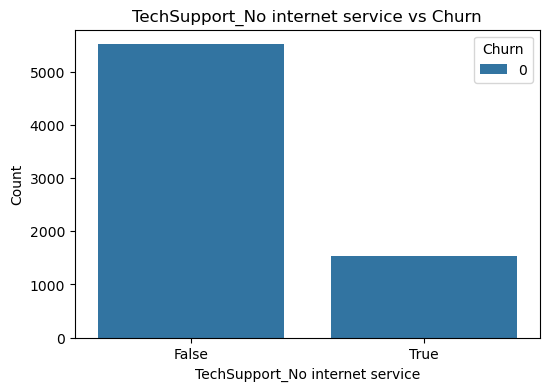

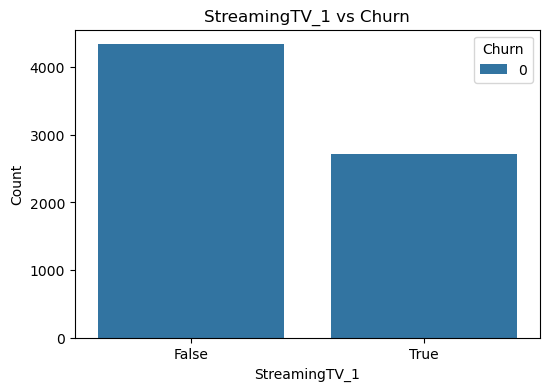

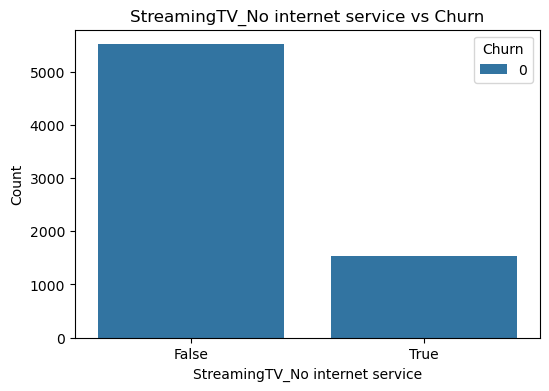

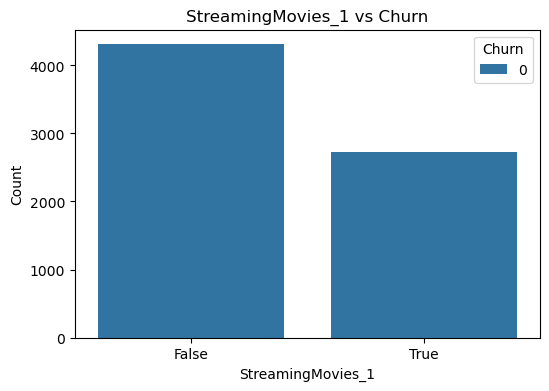

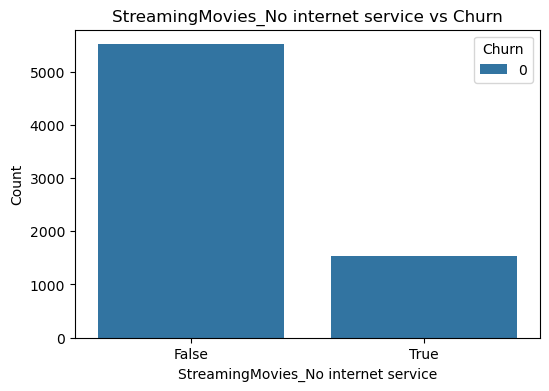

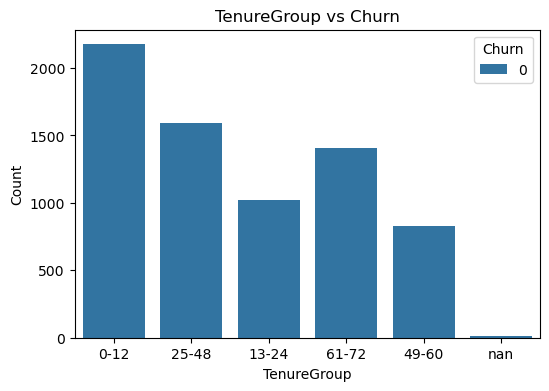

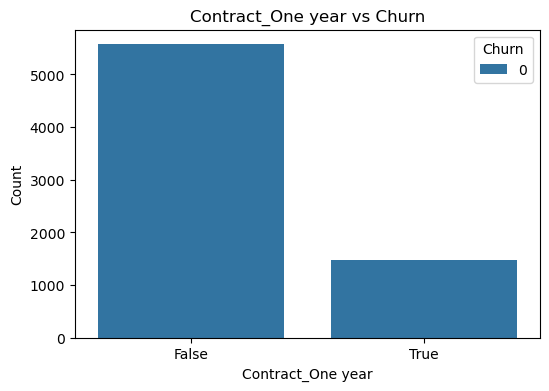

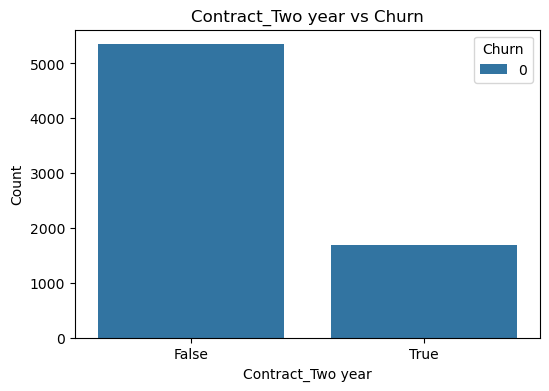

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# -----------------------------
# Clean Churn column
# -----------------------------
df = df.copy()
df["Churn"] = df["Churn"].fillna(0).astype(int).astype(str)

# -----------------------------
# Columns to skip
# -----------------------------
skip_cols = [
    "numAdminTickets", "numTechTickets", "PhoneService", "SeniorCitizen",
    "gender", "Partner", "Dependents", "PaperlessBilling"
]

# -----------------------------
# 1. Numeric features (boxplots)
# -----------------------------
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if "Churn" in num_cols:
    num_cols.remove("Churn")

for col in num_cols:
    if col in skip_cols:
        continue
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df["Churn"], y=df[col])
    plt.title(f"{col} vs Churn")
    plt.xlabel("Churn (0=No, 1=Yes)")
    plt.ylabel(col)
    plt.show()

# -----------------------------
# 2. Binary/Categorical features (bar charts)
# -----------------------------
cat_cols = [c for c in df.columns if c not in num_cols and c != "Churn" and c not in skip_cols]

for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=df[col].astype(str), hue=df["Churn"])
    plt.title(f"{col} vs Churn")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

# -----------------------------
# 3. One-hot encoded Contract features (bar charts)
# -----------------------------
contract_cols = [c for c in df.columns if "Contract" in c and c not in skip_cols]

for col in contract_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=df[col].astype(str), hue=df["Churn"])
    plt.title(f"{col} vs Churn")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


Multivariate Analysis

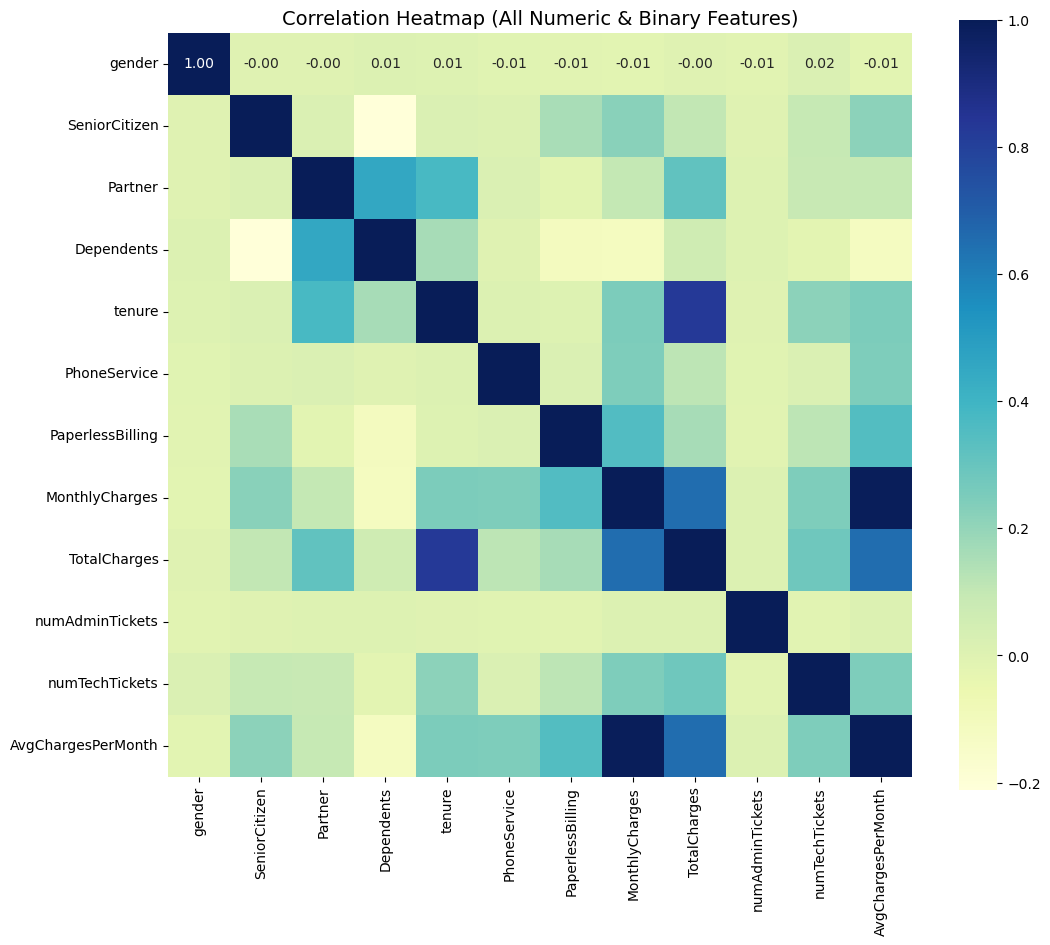

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/axisgrid.py:1507: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  func(x=vector, **plot_kwargs)
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/axisgrid.py:1507: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  func(x=vector, **plot_kwargs)
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_con

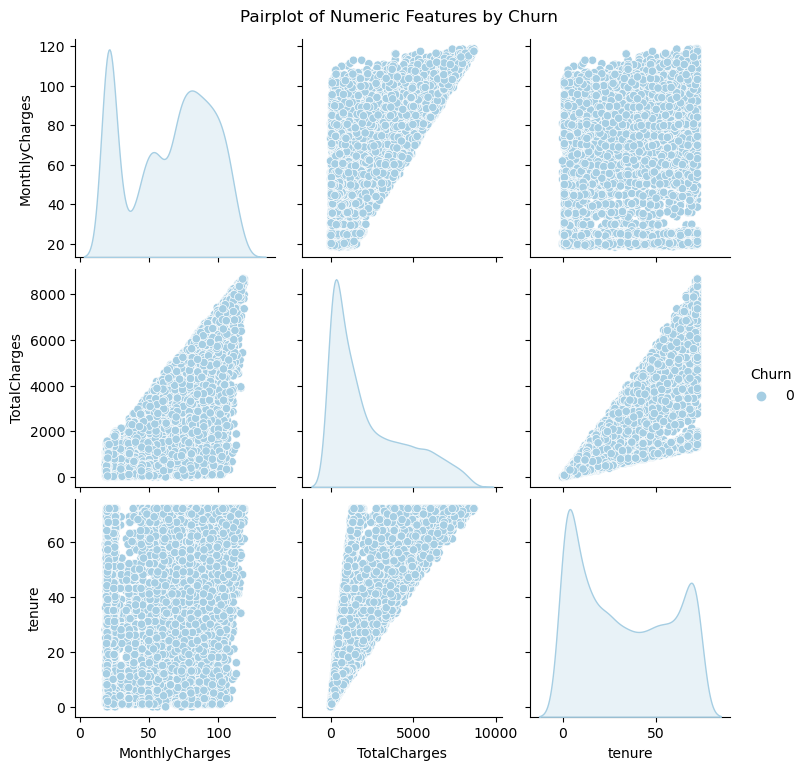

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# -----------------------------
# Clean Churn column
# -----------------------------
df = df.copy()
df["Churn"] = df["Churn"].fillna(0).astype(int)  # numeric for correlation/pairplot

# -----------------------------
# 1. Correlation Heatmap (all numeric + binary features)
# -----------------------------
# Select numeric columns and remove constant columns
all_numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns if df[c].nunique() > 1]

# Fill NaNs with 0 to avoid white spaces
corr_all = df[all_numeric_cols].fillna(0).corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_all, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True, square=True)
plt.title("Correlation Heatmap (All Numeric & Binary Features)", fontsize=14)
plt.show()

# -----------------------------
# 2. Pairplot for true numeric features only
# -----------------------------
numeric_cols = ["MonthlyCharges", "TotalCharges", "tenure"]  # true numeric features

sns.pairplot(
    df[numeric_cols + ["Churn"]],
    hue="Churn",
    palette=["#a6cee3","#fb9a99"],  # pastel colors
    diag_kind="kde"
)
plt.suptitle("Pairplot of Numeric Features by Churn", y=1.02)
plt.show()


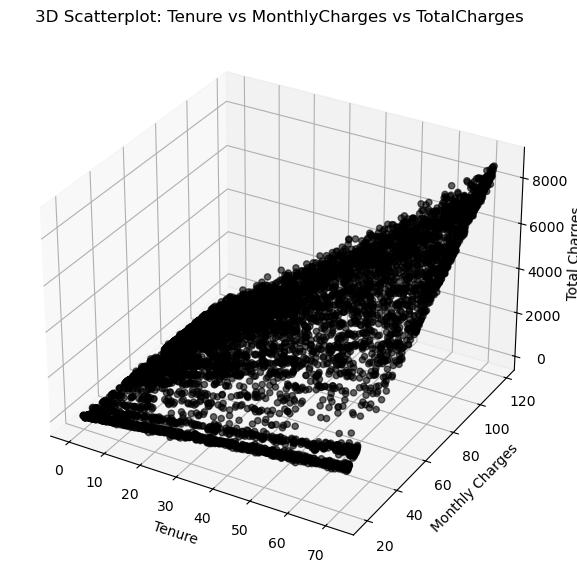

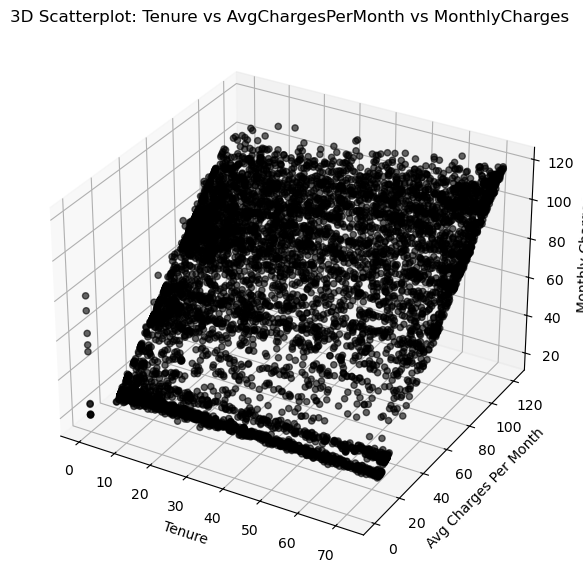

In [8]:
# =========================
# Multivariate Analysis
# =========================

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1st 3D Scatterplot: tenure, MonthlyCharges, TotalCharges
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['tenure'], df['MonthlyCharges'], df['TotalCharges'],
           c=df['Churn'].map({'Yes': 'red', 'No': 'blue'}), alpha=0.6)
ax.set_xlabel('Tenure')
ax.set_ylabel('Monthly Charges')
ax.set_zlabel('Total Charges')
ax.set_title('3D Scatterplot: Tenure vs MonthlyCharges vs TotalCharges')
plt.show()

# 2nd 3D Scatterplot: tenure, AvgChargesPerMonth, MonthlyCharges
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['tenure'], df['AvgChargesPerMonth'], df['MonthlyCharges'],
           c=df['Churn'].map({'Yes': 'red', 'No': 'blue'}), alpha=0.6)
ax.set_xlabel('Tenure')
ax.set_ylabel('Avg Charges Per Month')
ax.set_zlabel('Monthly Charges')
ax.set_title('3D Scatterplot: Tenure vs AvgChargesPerMonth vs MonthlyCharges')
plt.show()


Skewness of TotalCharges before transformation: 0.9630


/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Skewness of TotalCharges after transformation: -0.8243



/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


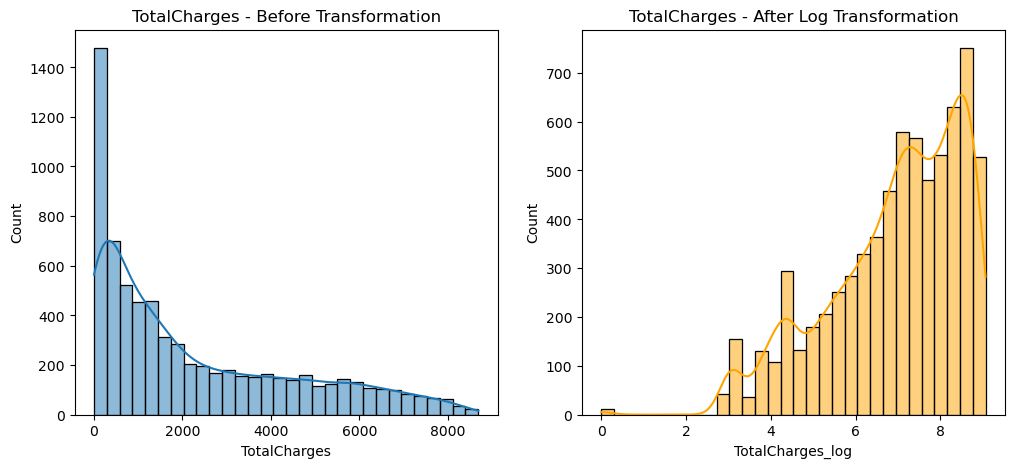

Skewness of AvgChargesPerMonth before transformation: -0.2143


/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Skewness of AvgChargesPerMonth after transformation: -1.0912



/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


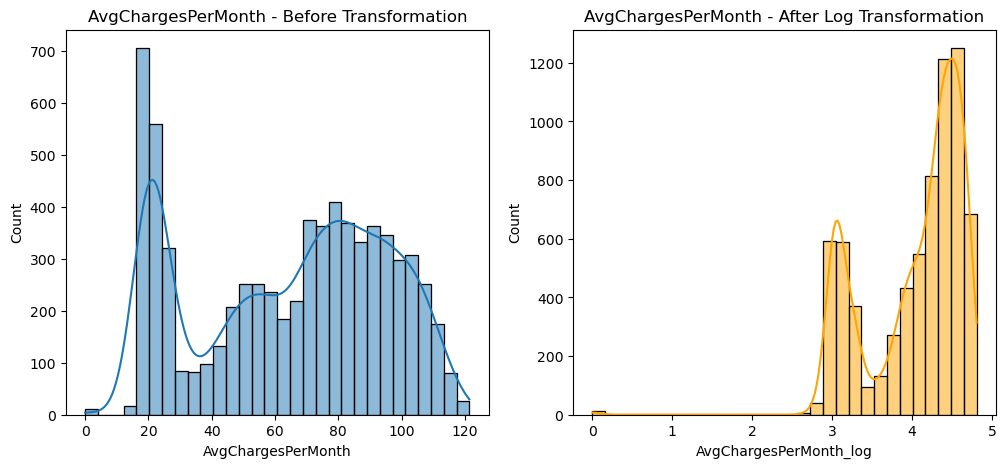

In [9]:
# === LIBRARIES ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

# === LOAD DATA ===
file_path = "02 Churn-Dataset.xlsx"
df = pd.read_excel(file_path, sheet_name="01 Churn-Dataset")

# === PREPROCESSING ===
# Convert TotalCharges to numeric (object -> float)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Fill NaNs with 0
df["TotalCharges"].fillna(0, inplace=True)

# Encode binary categorical variables
binary_map = {"Yes": 1, "No": 0, "Female": 0, "Male": 1}
df.replace(binary_map, inplace=True)

# Encode churn separately
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=[
    "InternetService", "Contract", "PaymentMethod", "MultipleLines",
    "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies"
], drop_first=True)

# Drop customerID
df.drop("customerID", axis=1, inplace=True)

# Feature engineering
df["AvgChargesPerMonth"] = df.apply(
    lambda x: x["TotalCharges"]/x["tenure"] if x["tenure"] > 0 else 0, axis=1
)
df["TenureGroup"] = pd.cut(df["tenure"], bins=[0,12,24,48,60,72], 
                           labels=["0-12","13-24","25-48","49-60","61-72"])

# === VISUALIZE TRANSFORMATION ===
features_to_check = ["TotalCharges", "AvgChargesPerMonth"]

for col in features_to_check:
    # Skewness before
    skew_before = skew(df[col])
    print(f"Skewness of {col} before transformation: {skew_before:.4f}")

    # Plot before transformation
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"{col} - Before Transformation")

    # Apply log1p transformation (log(1+x)) to handle skewness
    df[col+"_log"] = np.log1p(df[col])

    # Skewness after
    skew_after = skew(df[col+"_log"])
    print(f"Skewness of {col} after transformation: {skew_after:.4f}\n")

    # Plot after transformation
    plt.subplot(1,2,2)
    sns.histplot(df[col+"_log"], kde=True, bins=30, color="orange")
    plt.title(f"{col} - After Log Transformation")

    plt.show()
